In [1]:
%load_ext autoreload
%autoreload 2

In [27]:
import torch
from torch import nn
from torch.distributions.categorical import Categorical

import matplotlib.pyplot as plt
import pickle
import numpy as np
import os, sys
from tqdm.auto import tqdm


In [4]:
with open("/data/vision/phillipi/akumar01/synthetic-mdps-data/datasets_old/procgen/bigfish/dataset.pkl", "rb") as f:
    dataset = pickle.load(f)

In [5]:
dataset['obs'].shape

(64, 4096, 64, 64, 3)

In [19]:
def layer_init_normed(layer, norm_dim, scale=1.0):
    with torch.no_grad():
        layer.weight.data *= scale / layer.weight.norm(dim=norm_dim, p=2, keepdim=True)
        layer.bias *= 0
    return layer

class ResidualBlock(nn.Module):
    def __init__(self, channels, scale):
        super().__init__()
        # scale = (1/3**0.5 * 1/2**0.5)**0.5 # For default IMPALA CNN this is the final scale value in the PPG code
        scale = np.sqrt(scale)
        conv0 = nn.Conv2d(in_channels=channels, out_channels=channels, kernel_size=3, padding=1)
        self.conv0 = layer_init_normed(conv0, norm_dim=(1, 2, 3), scale=scale)
        conv1 = nn.Conv2d(in_channels=channels, out_channels=channels, kernel_size=3, padding=1)
        self.conv1 = layer_init_normed(conv1, norm_dim=(1, 2, 3), scale=scale)

    def forward(self, x):
        inputs = x
        x = nn.functional.relu(x)
        x = self.conv0(x)
        x = nn.functional.relu(x)
        x = self.conv1(x)
        return x + inputs


class ConvSequence(nn.Module):
    def __init__(self, input_shape, out_channels, scale):
        super().__init__()
        self._input_shape = input_shape
        self._out_channels = out_channels
        conv = nn.Conv2d(in_channels=self._input_shape[0], out_channels=self._out_channels, kernel_size=3, padding=1)
        self.conv = layer_init_normed(conv, norm_dim=(1, 2, 3), scale=1.0)
        nblocks = 2  # Set to the number of residual blocks
        scale = scale / np.sqrt(nblocks)
        self.res_block0 = ResidualBlock(self._out_channels, scale=scale)
        self.res_block1 = ResidualBlock(self._out_channels, scale=scale)

    def forward(self, x):
        x = self.conv(x)
        x = nn.functional.max_pool2d(x, kernel_size=3, stride=2, padding=1)
        x = self.res_block0(x)
        x = self.res_block1(x)
        assert x.shape[1:] == self.get_output_shape()
        return x

    def get_output_shape(self):
        _c, h, w = self._input_shape
        return (self._out_channels, (h + 1) // 2, (w + 1) // 2)


class Agent(nn.Module):
    def __init__(self):
        super().__init__()
        h, w, c = (64, 64, 3)
        shape = (c, h, w)
        conv_seqs = []
        chans = [16, 32, 32]
        scale = 1 / np.sqrt(len(chans))  # Not fully sure about the logic behind this but its used in PPG code
        for out_channels in chans:
            conv_seq = ConvSequence(shape, out_channels, scale=scale)
            shape = conv_seq.get_output_shape()
            conv_seqs.append(conv_seq)

        encodertop = nn.Linear(in_features=shape[0] * shape[1] * shape[2], out_features=256)
        encodertop = layer_init_normed(encodertop, norm_dim=1, scale=1.4)
        conv_seqs += [
            nn.Flatten(),
            nn.ReLU(),
            encodertop,
            nn.ReLU(),
        ]
        self.network = nn.Sequential(*conv_seqs)
        self.actor = layer_init_normed(nn.Linear(256, 15), norm_dim=1, scale=0.1)
        self.critic = layer_init_normed(nn.Linear(256, 1), norm_dim=1, scale=0.1)
        self.aux_critic = layer_init_normed(nn.Linear(256, 1), norm_dim=1, scale=0.1)

    def get_action_and_value(self, x, action=None):
        hidden = self.network(x.permute((0, 3, 1, 2)) / 255.0)  # "bhwc" -> "bchw"
        logits = self.actor(hidden)
        probs = Categorical(logits=logits)
        if action is None:
            action = probs.sample()
        return action, probs.log_prob(action), probs.entropy(), self.critic(hidden.detach()), logits

    def get_value(self, x):
        return self.critic(self.network(x.permute((0, 3, 1, 2)) / 255.0))  # "bhwc" -> "bchw"

    # PPG logic:
    def get_pi_value_and_aux_value(self, x):
        hidden = self.network(x.permute((0, 3, 1, 2)) / 255.0)
        return Categorical(logits=self.actor(hidden)), self.critic(hidden.detach()), self.aux_critic(hidden)

    def get_pi(self, x):
        return Categorical(logits=self.actor(self.network(x.permute((0, 3, 1, 2)) / 255.0)))


In [39]:
device = 'cuda'
agent = Agent().to(device)
opt = torch.optim.Adam(agent.parameters(), lr=3e-4)
bs = 32

n, t, *_ = dataset['obs'].shape

losses = []
pbar = tqdm(range(10000))
for i in pbar:
    i_n, i_t = np.random.randint(0, n, bs), np.random.randint(0, t, bs)
    
    x_batch = dataset['obs'][i_n, i_t]
    y_batch = dataset['act'][i_n, i_t]
    
    x_batch = torch.from_numpy(x_batch).to(device)/255.0
    y_batch = torch.from_numpy(y_batch).to(device).to(int)
    
    action, log_prob, entropy, value, logits = agent.get_action_and_value(x_batch)
    loss = nn.functional.cross_entropy(logits, y_batch)
    
    opt.zero_grad()
    loss.backward()
    opt.step()
    
    losses.append(loss.item())
    pbar.set_postfix(loss=loss.item())
    
    

  0%|          | 0/10000 [00:00<?, ?it/s]

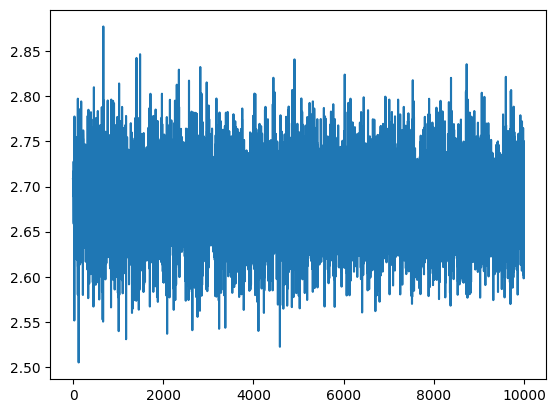

In [40]:
plt.plot(losses)